### Comparison of the coherence metric between the original and surrogate data

In [53]:
# Path to the toolbox
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from frites.conn.conn_spec import conn_spec
from frites.utils import parallel_func
from mne.viz import circular_layout, plot_connectivity_circle
from scipy.stats import ks_2samp, ttest_ind
from tqdm import tqdm

import GDa.graphics.plot as plot
import GDa.stats.bursting as bst
from GDa.session import session
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.temporal_network import temporal_network

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
# Create directory to save figures
if not os.path.exists("img/n3.0.4"):
    os.makedirs("img/n3.0.4")

In [65]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t

#### Load data

In [4]:
#  Instantiating session
ses = session(
    raw_path="../GrayLab/",
    monkey="lucy",
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)
# Load data
ses.read_from_mat()

In [5]:
# Get data for odrt
data = ses.filter_trials([1], [1])
# Surrogate data
data_surr = trial_swap_surrogates(data, seed=0, verbose=False)

#### Compute coherece

In [6]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
delta = 20  # Downsampling factor
mode = "multitaper"
freqs = np.linspace(3, 75, 10)
n_cycles = freqs / 4
mt_bandwidth = None

In [7]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
delta = 20  # Downsampling factor
mode = "multitaper"  # ("morlet", "mt_1", "mt_2")
metric = "coh"
foi = np.array([[0, 6.0], [6.0, 14.0], [14.0, 26.0], [26.0, 42.0], [42.0, 80.0]])

# if mode in ["morlet", "mt_1"]:
#  n_freqs = 15
freqs = np.linspace(3, 75, 10)
n_cycles = freqs / 4
mt_bandwidth = None

kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=10,
    pairs=None,
    sfreq=ses.data.attrs["fsample"],
    mode=mode,
    n_cycles=n_cycles,
    decim=delta,
    metric=metric,
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    sm_kernel=sm_kernel,
    block_size=4,
)

In [8]:
# Coherence for original data
coh = conn_spec(data, **kw).astype(np.float32, keep_attrs=True)
coh_surr = conn_spec(data_surr, **kw).astype(np.float32, keep_attrs=True)

Computing pairwise Coherence (n_pairs=4371, n_freqs=10, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    3.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...82 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.1s finished


  0%|          | Estimating pairwise Coherence for trials 83...165 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.2s finished


  0%|          | Estimating pairwise Coherence for trials 166...248 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.4s finished


  0%|          | Estimating pairwise Coherence for trials 249...331 : 0/4371 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=4371, n_freqs=10, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...82 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.2s finished


  0%|          | Estimating pairwise Coherence for trials 83...165 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.6s finished


  0%|          | Estimating pairwise Coherence for trials 166...248 : 0/4371 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    4.8s finished


  0%|          | Estimating pairwise Coherence for trials 249...331 : 0/4371 [00:00<?,       ?it/s]

In [18]:
coh = coh.transpose("roi", "freqs", "trials", "times")
coh_surr = coh_surr.transpose("roi", "freqs", "trials", "times")

In [19]:
roi_s, roi_t, _ = _extract_roi(coh.roi.values, "-")

#### Statistical testing the distributions (KS-test and t-test)

The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

**ks-test:** If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.

**t-test:**  A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance.

In [20]:
def significance_test(verbose=False, n_jobs=1):
    """
    Method to compute the ks- and t-test for each frequency band
    in parallel.
    """

    def _for_band(band):
        # Store p-value for KS-test
        ks = np.zeros(coh.shape[0])
        # Store p-value for t-test
        tt = np.zeros(coh.shape[0])
        for i in range(coh.shape[0]):
            ks[i] = ks_2samp(
                coh[i, band, ...].values.flatten(),
                coh_surr[i, band, ...].values.flatten(),
                alternative="two-sided",
            )[1]
            tt[i] = ttest_ind(
                coh[i, band, ...].values.flatten(),
                coh_surr[i, band, ...].values.flatten(),
                alternative="two-sided",
                equal_var=False,
            )[1]
        return np.array([ks, tt])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_band, n_jobs=n_jobs, verbose=verbose, total=coh.shape[1]
    )
    p_values = parallel(p_fun(band) for band in range(coh.shape[1]))
    return np.asarray(p_values).T

In [21]:
p_values = significance_test(verbose=True, n_jobs=5)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  6.2min finished


In [23]:
# p-values
p = 0.05

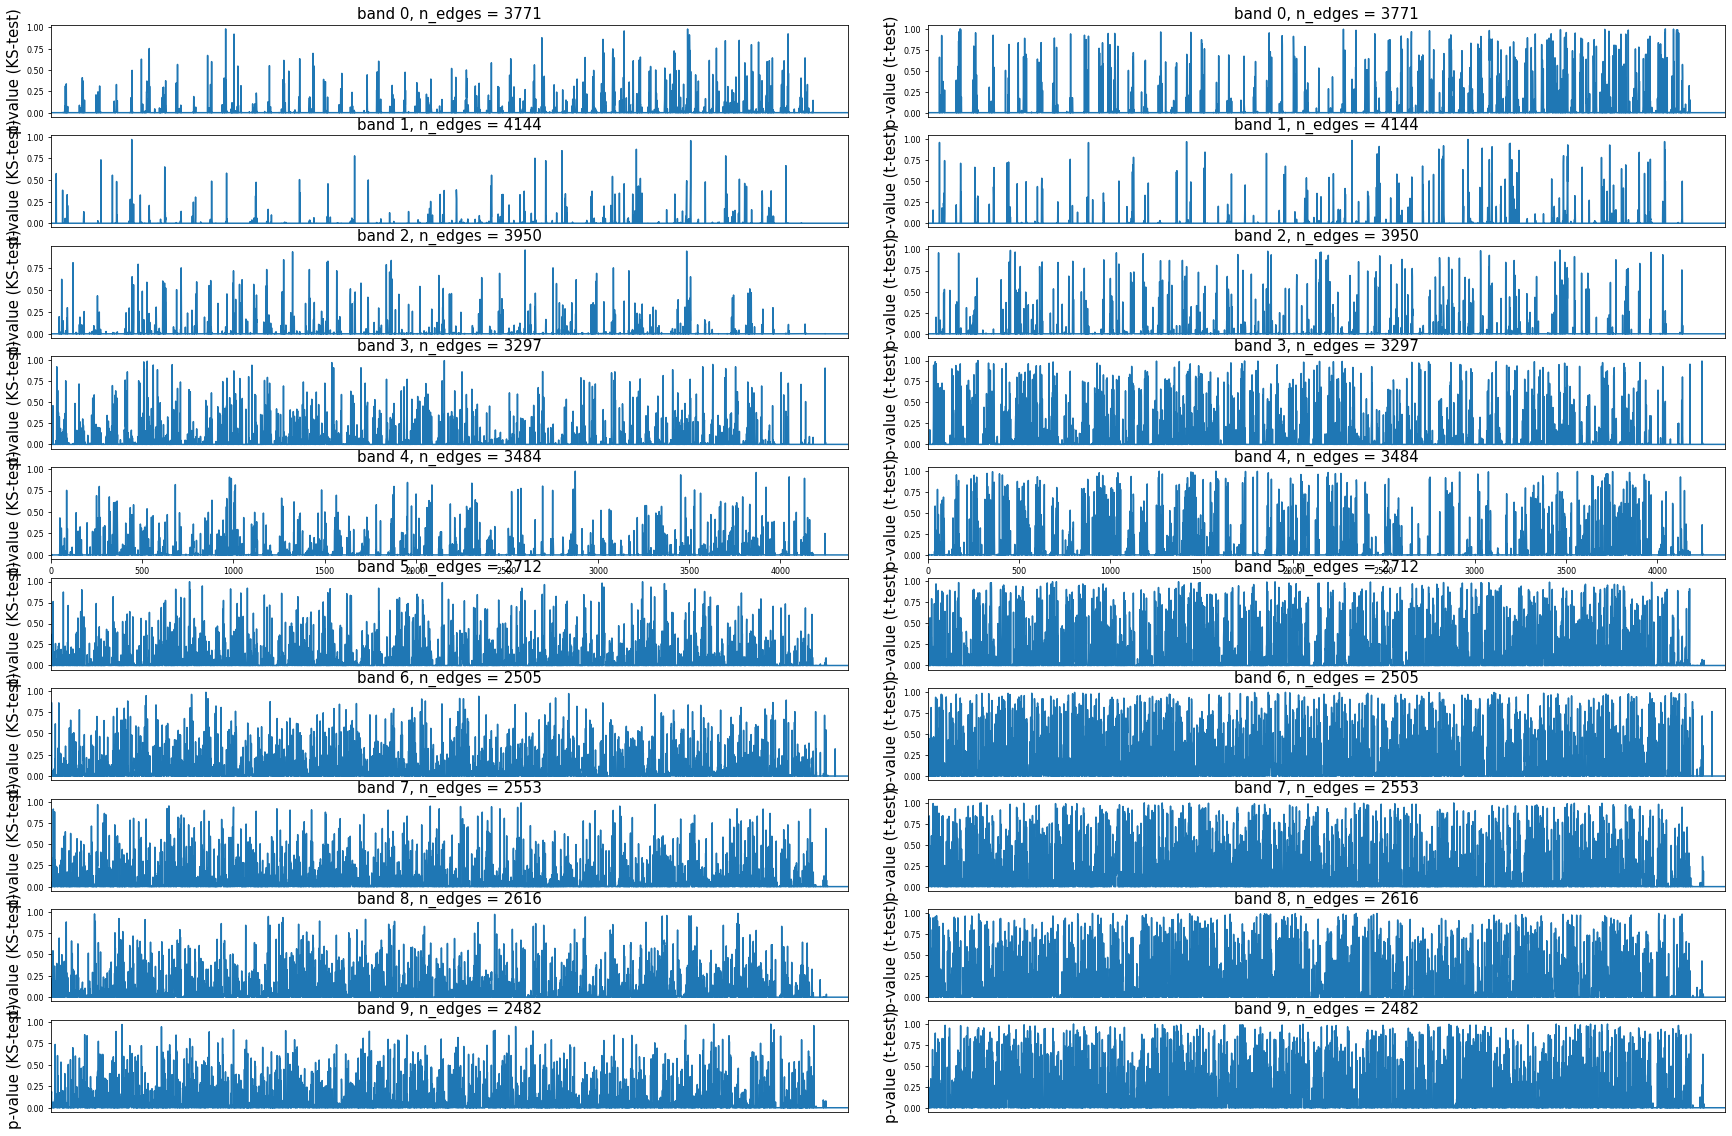

In [28]:
plt.figure(figsize=(30, 20))
count = 1
for i in range(coh.sizes["freqs"]):
    plt.subplot(10, 2, count)
    # Plot KS-test p-value
    plt.plot(p_values[:, 0, i])
    plt.ylabel("p-value (KS-test)", fontsize=15)
    plt.title(f"band {i}, n_edges = {np.sum(p_values[:,1,i]<p)}", fontsize=15)
    plt.xlim([0, p_values.shape[0]])
    if i == 4:
        plt.xlabel("Edge number", fontsize=15)
    else:
        plt.xticks([])
    count += 1
    plt.subplot(10, 2, count)
    # Plot t-test p-value
    plt.plot(p_values[:, 1, i])
    plt.ylabel("p-value (t-test)", fontsize=15)
    count += 1
    if i == 4:
        plt.xlabel("Edge number", fontsize=15)
    else:
        plt.xticks([])
    plt.title(f"band {i}, n_edges = {np.sum(p_values[:,1,i]<p)}", fontsize=15)
    plt.xlim([0, p_values.shape[0]])
plt.subplots_adjust(wspace=0.1)
plt.savefig("img/n3.0.4/ks_test.png", dpi=200)

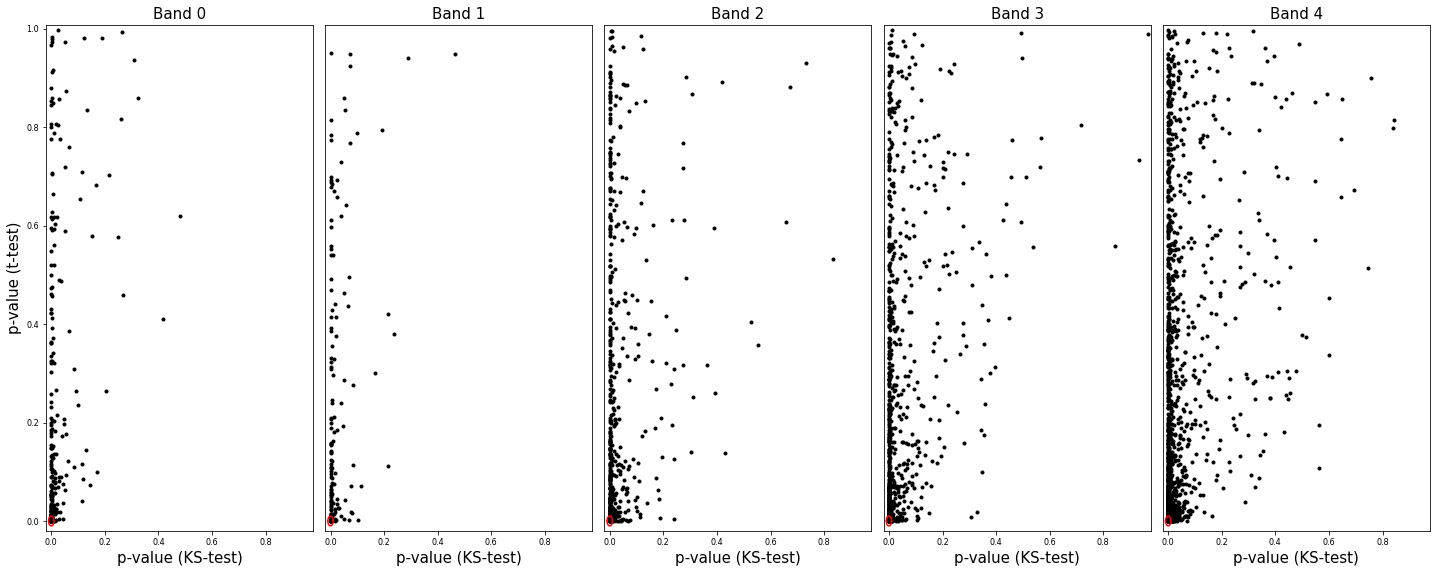

In [14]:
plt.figure(figsize=(20, 8))
for i in range(net.super_tensor.sizes["freqs"]):
    plt.subplot(1, 5, i + 1)
    # Create scatter plot
    plt.scatter(p_values[:, 0, i], p_values[:, 1, i], marker=".", color="k")
    # Surround the area corresponding to the links with low p-value
    x = np.linspace(-p, p, 100)
    y = np.sqrt(p ** 2 - x ** 2)
    plt.plot(x, y, "r")
    plt.plot(x, -y, "r")
    if i == 0:
        plt.ylabel("p-value (t-test)", fontsize=15)
    if i > 0:
        plt.yticks([])
    plt.xlabel("p-value (KS-test)", fontsize=15)
    plt.title(f"Band {i}", fontsize=15)
    plt.ylim(-0.02, p_values[:, 1, :].max() + 0.01)
    plt.xlim(-0.02, p_values[:, 0, :].max() + 0.01)
plt.tight_layout()

#### Checking a few histograms with p<0.05

In [29]:
# Siginificant links in all bands (KS-test)
ks_idx = (
    (p_values[:, 0, 0] < p)
    * (p_values[:, 0, 1] < p)
    * (p_values[:, 0, 2] < p)
    * (p_values[:, 0, 3] < p)
    * (p_values[:, 0, 4] < p)
)
# Siginificant links in all bands (t-test)
tt_idx = (
    (p_values[:, 1, 0] < p)
    * (p_values[:, 1, 1] < p)
    * (p_values[:, 1, 2] < p)
    * (p_values[:, 1, 3] < p)
    * (p_values[:, 1, 4] < p)
)
# Siginificant links in all bands (KS-test + t-test)
idx = ks_idx * tt_idx

In [30]:
# Sample four edge indexes
ei = np.sort(np.random.choice(np.where(idx == True)[0], 4))

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


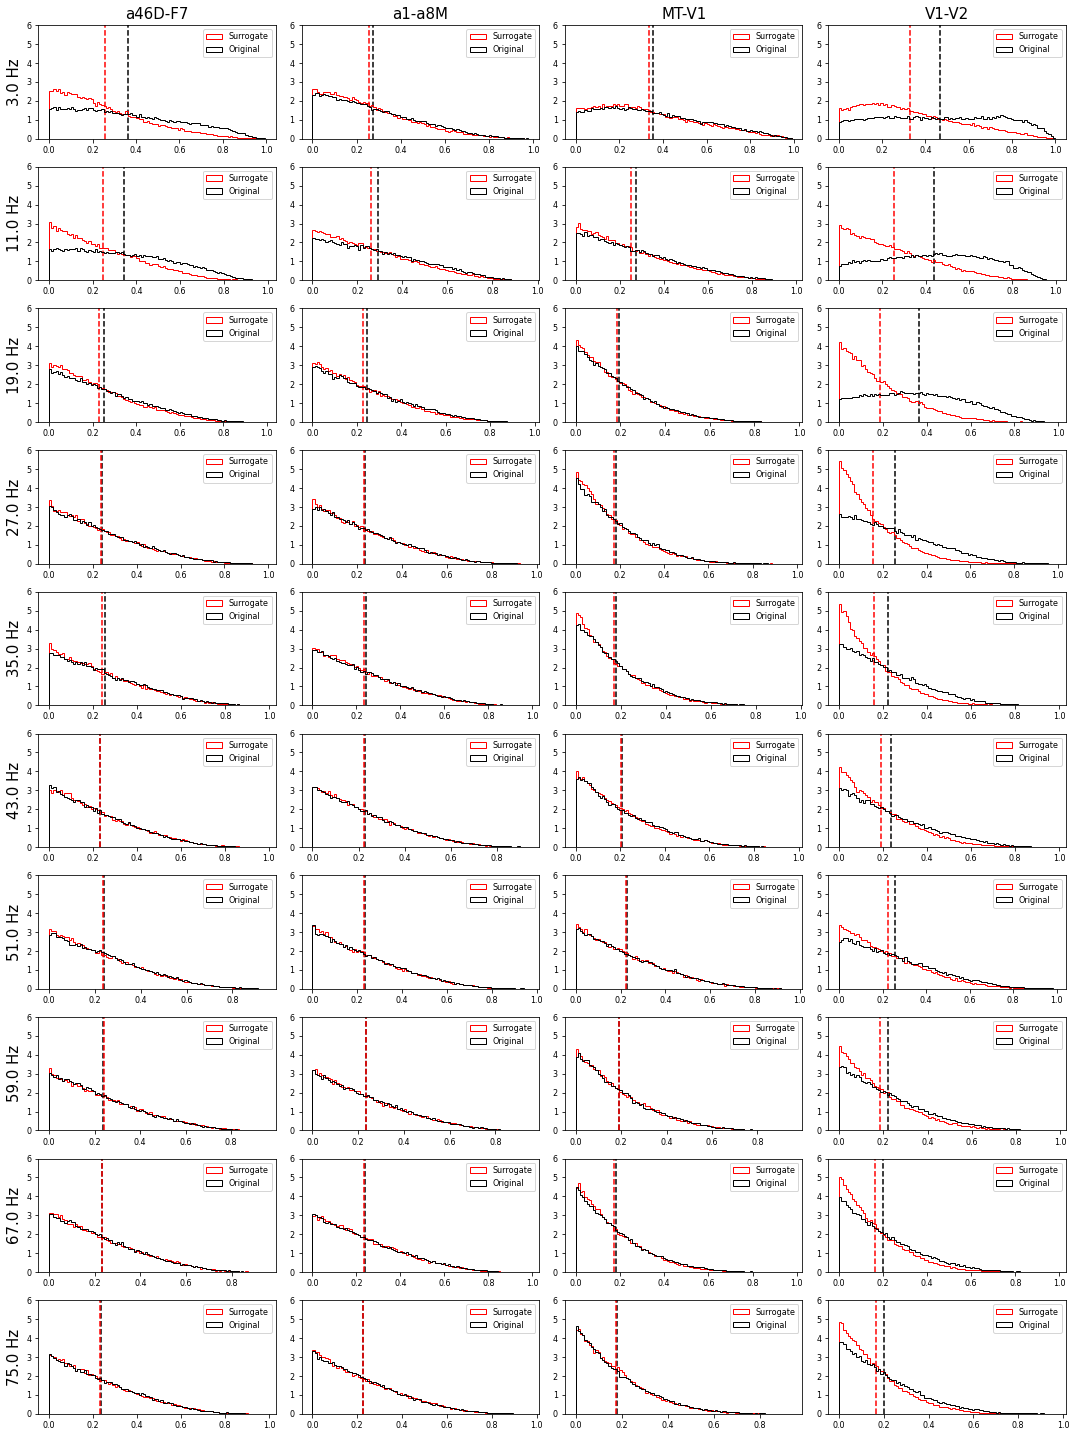

In [44]:
# Saving distributions for trial shuffling surrogates
count = 1
y_max = np.array([3, 4, 5, 5, 7]) + 3
plt.figure(figsize=(15, 20))
for i in tqdm(range(coh.sizes["freqs"])):
    for r in ei:  # tqdm( range(coh.sizes['roi']) ):
        bins = np.linspace(coh[r, i, ...].min(), coh[r, i, ...].max(), 100)
        plt.subplot(coh.sizes["freqs"], len(ei), count)
        plt.hist(
            coh_surr[r, i, ...].values.flatten(),
            bins=bins,
            density=True,
            histtype="step",
            fill=False,
            color="r",
            label=f"Surrogate",
        )
        plt.hist(
            coh[r, i, ...].values.flatten(),
            bins=bins,
            density=True,
            histtype="step",
            fill=False,
            color="k",
            label="Original",
            lw=1,
        )
        # Compute mean to plot
        m_orig = coh[r, i, ...].mean()
        m_surr = coh_surr[r, i, ...].mean()
        # Plot mean values as vertical bar
        plt.ylim(0, 6)
        plt.vlines(m_orig, 0, 10, colors="k", linestyles="dashed")
        plt.vlines(m_surr, 0, 10, colors="r", linestyles="dashed")
        if r == ei[0]: plt.ylabel(f"{coh.freqs.data[i]} Hz", fontsize=15)
        if i == 0: plt.title(f"{coh.roi.data[r]}", fontsize=15)
        plt.legend()
        count += 1
plt.tight_layout()

### Plotting number of siginificant links for each pair of regions

In [180]:
p_values = xr.DataArray(p_values, dims = ("roi", "p", "freqs"), 
                        coords=dict(roi=coh.roi.data, 
                                    freqs=coh.freqs.data,
                                    p=["ks", "t"]))

In [181]:
p_sig = (p_values<0.05).groupby("roi").sum("roi")

In [163]:
p_mat = xr.DataArray(np.zeros((n_rois, n_rois, 2, p_sig.sizes["freqs"])), 
                     dims=("sources", "targets", "p", "freqs"), 
                     coords=dict(sources=unique_rois,
                                 targets=unique_rois,
                                 p=["ks", "t"],
                                 freqs=p_sig.freqs.data)
                    )

In [167]:
for p, roi in enumerate(p_sig.roi.data):
    x, y = roi.split('-')
    s, t = mapping[x], mapping[y]
    p_mat[s,t] = p_mat[t,s] = p_sig[p]

In [211]:
roi_s, roi_t = _extract_roi(p_sig.roi.data, '-')
unique_rois = np.unique(np.concatenate((roi_s, roi_t)))
mapping = dict(zip(unique_rois, range(len(unique_rois))))
n_rois = len(unique_rois)


def plot_conn_sig(band, _colorbar=False, subplot=111):
    """
    Plot connectivity circle with links with
    signigicant coherence distribution for a given band
    """


    fig = plt.figure(figsize=(20, 20))
    plot_connectivity_circle(
        p_mat.isel(freqs=band, p=1).data,
        unique_rois,
        colormap="hot_r",
        facecolor="white",
        vmin=0,
        vmax=70,
        textcolor="k",
        fig=None,
        colorbar=_colorbar,
        padding=3,
        colorbar_size=0.4,
        colorbar_pos=(-1, 0.5),
        linewidth=3,
        title=f"{p_mat.freqs.data[band]} Hz",
        fontsize_title=20,
        fontsize_names=12,
        subplot=subplot,
        show=False,
    )
    plt.savefig(
        f"img/n3.0.4/sig_links_b{band}_ks{sm_times}.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()


def plot_circles(ax, band, ks):
    """
    Plot olympics circles to the given axes.
    """

    png = plt.imread(f"img/n3.0.4/sig_links_b{band}_ks{ks}.png")
    plt.sca(ax)
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")
    pad = 2
    plt.xlim(-pad, png.shape[1] + pad)
    plt.ylim(png.shape[0] + pad, -pad)
    return png


def plot_legend(ax):
    png = plt.imread(f"img/n3.0.4/legend_areas.png")
    plt.sca(ax)
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")
    pad = 2
    plt.xlim(-pad, png.shape[1] + pad)
    plt.ylim(png.shape[0] + pad, -pad)
    return png

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

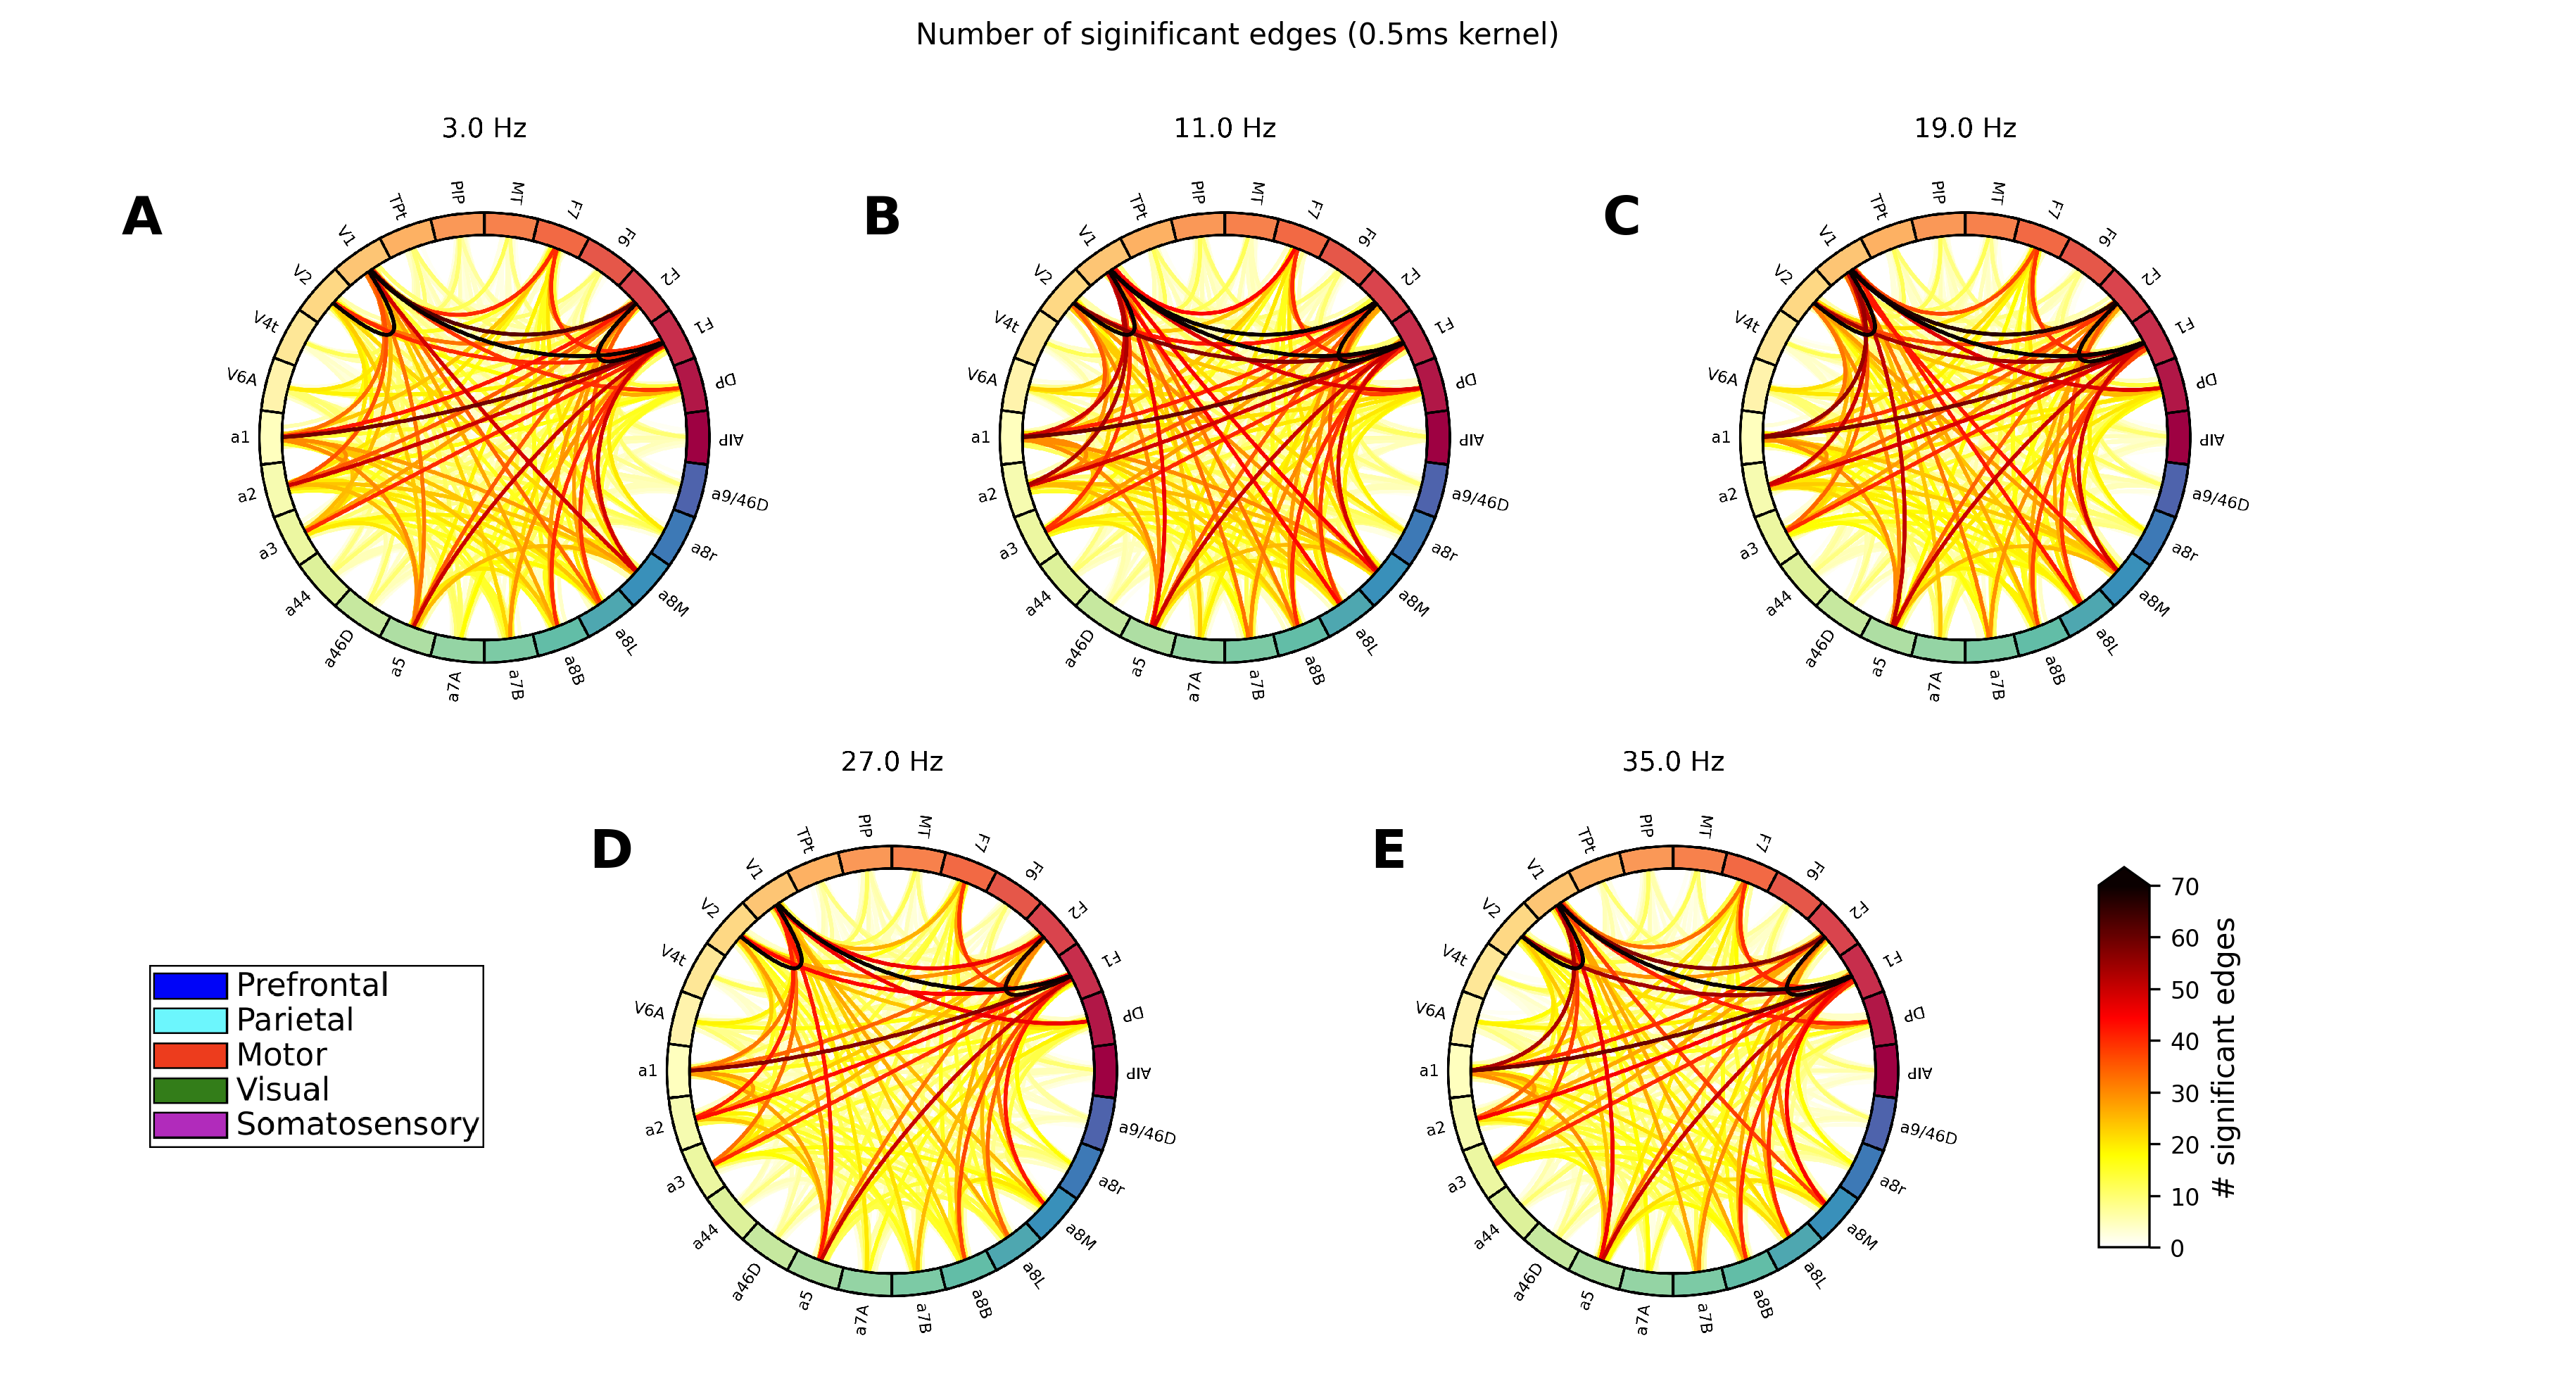

In [212]:
fig = plt.figure(figsize=(12, 6), dpi=300)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    width_ratios=(1, 1, 1),
    left=0.05,
    right=0.9,
    bottom=0.5,
    top=1,
    wspace=0.1,
    hspace=0,
)
gs2 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    width_ratios=(0.45, 1.0, 1.0),
    left=0.05,
    right=0.80,
    bottom=0.0,
    top=0.5,
    wspace=0.05,
    hspace=0,
)

gs3 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.82,
    right=0.84,
    bottom=0.1,
    top=0.4,
    wspace=0.05,
    hspace=0,
)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])

# SAVING CONNECTIVITY CIRCLES FOR BANDS 0,1,2
plot_conn_sig(0, _colorbar=False, subplot=111)
plot_conn_sig(1, _colorbar=False, subplot=111)
plot_conn_sig(2, _colorbar=False, subplot=111)

# PLACING CONNECTIVITY IN THE GRID
plot_circles(ax1, 0, sm_times)
plot_circles(ax2, 1, sm_times)
plot_circles(ax3, 2, sm_times)

# Panel B
ax8 = plt.subplot(gs2[0])
ax5 = plt.subplot(gs2[1])
ax6 = plt.subplot(gs2[2])

# SAVING CONNECTIVITY CIRCLES FOR BANDS 0,1,2
plot_conn_sig(3, _colorbar=False, subplot=111)
plot_conn_sig(4, _colorbar=False, subplot=111)

# PUTTING LABEL WITH NAME OF THE REGIONS
plot_legend(ax8)
# PLACING CONNECTIVITY IN THE GRID
plot_circles(ax5, 3, sm_times)
plot_circles(ax6, 4, sm_times)


ax7 = plt.subplot(gs3[0])

# COLORBAR
norm = matplotlib.colors.Normalize(vmin=0, vmax=70)
cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.hot_r, norm=norm),
    cax=ax7,
    extend="max",
    shrink=0.1,
)
cbar.ax.set_ylabel("# significant edges", rotation="vertical")
# cbar.ax.tick_params(length=0)

# Background
bg = plot.Background(visible=False)
bg.axes.text(
    0.48,
    1.05,
    "Number of siginificant edges (0.5ms kernel)",
    ha="center",
    fontsize=MEDIUM_SIZE,
)

plot.add_panel_letters(
    fig,
    axes=[ax1, ax2, ax3, ax5, ax6],
    fontsize=18,
    xpos=[-0.1, -0.1, -0.1, -0.0, -0.0],
    ypos=[0.8] * 5,
)
plt.savefig(
    f"img/n3.0.4/significance_analysis.png", transparent=False, bbox_inches="tight"
)